In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# gloabl imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [3]:
# read ACSIncome data
df, decode = pickle.load(open('../data/ACSIncome.pckl', 'rb'))
# state names
states = decode['STATE'].values()
# pretty printing long labels
pretty_rac1p = ['White', 'Black', 'Indian', 'Alaskian', 'Alaskian-Indian', 'Asian', 'Hawaiian', 'Other', 'Two+']
decode['RAC1P'] = { (i+1):pretty_rac1p[i] for i in range(len(pretty_rac1p)) }
decode

{'COW': {1: 'Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions',
  2: 'Employee of a private not-for-profit, tax-exempt,or charitable organization',
  3: 'Local government employee (city, county, etc.)',
  4: 'State government employee',
  5: 'Federal government employee',
  6: 'Self-employed in own not incorporated business,professional practice, or farm',
  7: 'Self-employed in own incorporated business,professional practice or farm',
  8: 'Working without pay in family business or farm',
  9: 'Unemployed and last worked 5 years ago or earlier or never worked'},
 'SCHL': {1: 'No schooling completed',
  2: 'Nursery school, preschool',
  3: 'Kindergarten',
  4: 'Grade 1',
  5: 'Grade 2',
  6: 'Grade 3',
  7: 'Grade 4',
  8: 'Grade 5',
  9: 'Grade 6',
  10: 'Grade 7',
  11: 'Grade 8',
  12: 'Grade 9',
  13: 'Grade 10',
  14: 'Grade 11',
  15: '12th grade - no diploma',
  16: 'Regular high school diploma',
  17: 'GED or alternative

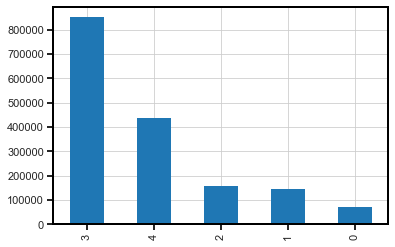

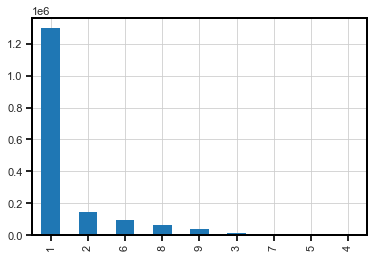

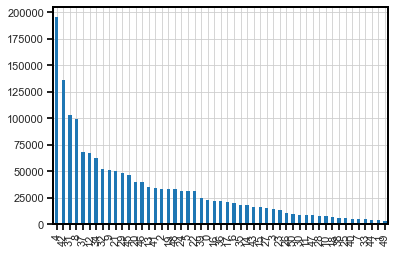

In [4]:
# distributions
df["WKHPgroup"].value_counts().plot(kind='bar')
plt.show()
df["RAC1P"].value_counts().plot(kind='bar')
plt.show()
df["STATE"].value_counts().plot(kind='bar')
plt.show()

In [5]:
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup
0,18,1,18,5,4720,13,21,2,2,0,0,0,16,0,1
1,53,5,17,5,3605,18,40,1,1,0,0,3,11,0,3
2,41,1,16,5,7330,1,40,1,1,0,0,1,21,0,3
3,18,6,18,5,2722,1,2,2,1,0,0,0,9,0,0
4,21,5,19,5,3870,12,50,1,1,0,0,0,12,0,4


In [6]:
# predictive attributes (for models)
pred_atts = ['WKHP', 'RAC1P', 'STATE']
pred_all = pred_atts + ['class']
# nominal attributes (for DD)
disc_atts = ['WKHPgroup', 'RAC1P', 'STATE']
disc_all = disc_atts + ['class']

# split train test
X = df[pred_atts]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.33, random_state=42)

In [7]:
# training model and make predictions - replace with your favorite classifier
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
y_pred_b = clf.predict(X_test)
df_test['pred_b'] = y_pred_b
# extend decode
decode['pred_b'] = decode['class']

In [8]:
'''
     contingency table for separation
          protected                                   unprotected
     ========= pred.bad  ==  pred.good  ===   ====  pred.bad  ==  pred.good  === 
     true.bad    TPp          FNp      Pp()           TPu           FNu      Pu()
     true.good   FPp          TNp      Np()           FPu           TNu      Nu()
     ==========   a     =====  b  ===  n1()   ====     c    ====     d  ===  n2()
'''
# Accuracy
def acc(ctg):
    return (ctg.TPp+ctg.TPu+ctg.TNp+ctg.TNu)/ctg.n()

# Equality of opportuniy - FairLearn version is
# P(pred.good|true.good) - P(pred.good|protected,true.good)
def eop_mean(ctg, disc):
    # at least 20 protected and some protected/unprotected negatives
    if ctg.a < 20 or ctg.Np()==0 or ctg.Nu()==0:
        return None
    # compute P(pred.good|true.good)
    trueGood = len(disc.itDB.cover(list(ctg.ctx)+[disc.trueGood]))
    predtrueGood =  len(disc.itDB.cover(list(ctg.ctx)+[disc.trueGood, disc.predGood]))
    #print(predtrueGood/trueGood)
    # end
    return predtrueGood/trueGood - ctg.tnrp()

# To compute P(pred.good|true.good) we need the dd.DD object
metric_b = lambda ctg: eop_mean(ctg, disc_b)

In [9]:
# discrimination in overall test set
disc_b = dd.DD(df_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_b=<=50K', trueBadItem='class=<=50K', valuedecode=decode)

In [10]:
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("Metric = {:f}".format(metric_b(ctg)))
print("ACC = {:f}".format(acc(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White                                     RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|       76144|       9305| 85449     class=<=50K|      211952|      49545|261497
class=>50K |       21666|      13770| 35436     class=>50K |       84227|      82676|166903
           |       97810|      23075|120885                |      296179|     132221|428400
Metric = 0.088068
ACC = 0.700077


In [11]:
# each protected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("Metric = {:f}".format(metric_b(ctg)))
# and for the unprotected, as fairlearn also consider it
print('-----\nUnprotected')
print("Metric = {:f}".format(metric_b(ctg)+ctg.tnrp()-ctg.tnru()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black                                     RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|       35518|       1050| 36568     class=<=50K|      211952|      49545|261497
class=>50K |       10485|       1466| 11951     class=>50K |       84227|      82676|166903
           |       46003|       2516| 48519                |      296179|     132221|428400
Metric = 0.353988
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Two+                                      RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|        8871|        849|  9720     class=<=50K|      211952|      49545|261497
class=>50K |        2799|       1321|  4120     class=>50K |       84227|      82676|166903
           |       11670|       2170| 13840                |      296179|     132221|428400
Metric = 0.156024
-----
Contex

In [12]:
# check with the Fairlearn metrics (see decoding of RAC1P for the order)
from fairlearn.reductions import TruePositiveRateParity # EOP is TPR given the coding of classes 
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import true_positive_rate

summary_b = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_b,
                          sensitive_features=X_test['RAC1P'])
summary_b.overall-summary_b.by_group

RAC1P
1   -0.018698
2    0.353988
3    0.401826
4    0.418684
5    0.476656
6   -0.283644
7    0.326458
8    0.475315
9    0.156024
Name: true_positive_rate, dtype: object

In [13]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
from fairlearn.postprocessing import ThresholdOptimizer

# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
#X_train = X_train.fillna(0) # fairlearn does not manage missing values
#X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P'], random_state=42).astype(int)
df_test['pred_a'] = y_pred_a
# extend decode
decode['pred_a'] = decode['class']

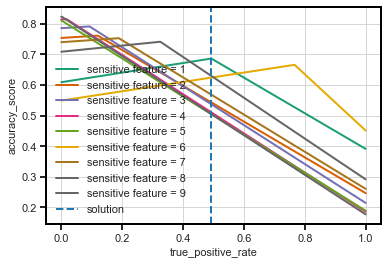

In [14]:
from fairlearn.postprocessing import plot_threshold_optimizer

plot_threshold_optimizer(postprocess_est)

In [15]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_a = lambda ctg: eop_mean(ctg, disc_a)

# discrimination in overall test set after correction
# DD(filename or dataframe, unprotected item, negative decision, negative truth)
disc_a = dd.DD(df_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_a=<=50K', trueBadItem='class=<=50K', valuedecode=decode,
               codes=disc_b.codes) # extends the coding of items as disc_b 

In [16]:
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_a.print(ctg)
print("Metric = {:f}".format(metric_a(ctg)))
print("ACC = {:f}".format(acc(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White                                     RAC1P=White
           |pred_a=<=50K|pred_a=>50K|                      |pred_a=<=50K|pred_a=>50K|      
class=<=50K|       51335|      34114| 85449     class=<=50K|      212003|      49494|261497
class=>50K |       18111|      17325| 35436     class=>50K |       84301|      82602|166903
           |       69446|      51439|120885                |      296304|     132096|428400
Metric = 0.004950
ACC = 0.661342


In [17]:
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("Metric = {:f}".format(metric_a(ctg)))
# and for the unprotected, as fairlearn also consider it
print('-----\nUnprotected')
print("Metric = {:f}".format(metric_a(ctg)+ctg.tnrp()-ctg.tnru()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black                                     RAC1P=White
           |pred_a=<=50K|pred_a=>50K|                      |pred_a=<=50K|pred_a=>50K|      
class=<=50K|       20608|      15960| 36568     class=<=50K|      212003|      49494|261497
class=>50K |        6065|       5886| 11951     class=>50K |       84301|      82602|166903
           |       26673|      21846| 48519                |      296304|     132096|428400
Metric = 0.001348
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Two+                                      RAC1P=White
           |pred_a=<=50K|pred_a=>50K|                      |pred_a=<=50K|pred_a=>50K|      
class=<=50K|        6654|       3066|  9720     class=<=50K|      212003|      49494|261497
class=>50K |        2137|       1983|  4120     class=>50K |       84301|      82602|166903
           |        8791|       5049| 13840                |      296304|     132096|428400
Metric = 0.012549
-----
Contex

In [18]:
# check with the Fairlearn metrics
summary_a = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_a,
                          sensitive_features=X_test['RAC1P'])
summary_a.overall-summary_a.by_group

RAC1P
1   -0.001051
2    0.001348
3    0.034676
4   -0.013387
5    0.005138
6    0.004666
7    0.055124
8   -0.000914
9    0.012549
Name: true_positive_rate, dtype: object

In [19]:
# Fairlearn fails if there is a sensitive group without instances in a control group, e.g., no Other race in some STATE
if False:
    summary_ac = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_a,
                          sensitive_features=X_test['RAC1P'],
                          control_features=X_test['STATE'])

In [45]:
def desc_l(v):
    return dd.get_val(v[0])+', '+dd.get_val(v[1])

def data_plot(disc_b, metric_b, disc_a, metric_a, unpr=False):
    acs = []
    xs = []
    ys = []
    descs = []
    for s in states:
        first = True
        for ctg_b in disc_b.ctg_global(['STATE='+s]):
            x = metric_b(ctg_b)
            # relativize ctg_b to disc_a
            ctg_a = disc_a.ctg_rel(ctg_b) 
            y = metric_a(ctg_a)
            if x is None or y is None:
                continue
            d = disc_b.ctg_info(ctg_b)
            if first:
                # unprotected dot
                x1 = metric_b(ctg_b)+ctg_b.tnrp()-ctg_b.tnru()
                y1 = metric_a(ctg_a)+ctg_a.tnrp()-ctg_a.tnru()
                # accuracy at State level
                ctg_b.protected = -1
                ctg_b = disc_b.ctg_rel(ctg_b) 
                ctg_a.protected = -1
                ctg_a = disc_a.ctg_rel(ctg_a)
                acc_diff = acc(ctg_b)-acc(ctg_a)
                # add unprotected
                if unpr:
                    xs.append(x1)
                    ys.append(y1)
                    descs.append((s, 'unprotected'))
                    acs.append(acc_diff)
                    #print(x1, y1, acc_diff)
                first = False
            xs.append(x)
            ys.append(y)
            descs.append(d)   
            acs.append(acc_diff)
    return xs, ys, descs, acs

xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_a, metric_a, True)
print('mean before', np.mean([abs(x) for x in xs]), 'after', np.mean([abs(y) for y in ys]), 'len', len(xs))
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_a, metric_a)

mean before 0.26624037549915536 after 0.12150184823480012 len 253


In [46]:
# development only
if False:
    for i in range(len(xs)):
        if xs[i]<-0 and ys[i]>0.2:
            print(i, xs[i], ys[i], ys[i]-xs[i], acs[i], descs[i])

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_13372\3828344671.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


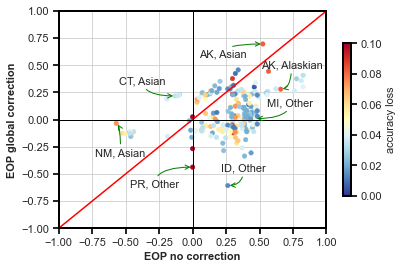

In [49]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP no correction", fontweight="bold")
plt.ylabel("EOP global correction", fontweight="bold")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
arrow_properties = dict(color='green', arrowstyle="->", connectionstyle="angle3,angleA=90,angleB=0")
id = 6 # 6 0.4711111111111111 0.7688888888888888 0.29777777777777775 0.07711651299245603 ('STATE=AK', 'RAC1P=Asian alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(0.4, 0.65), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 88 # 88 0.46383446255264604 0.007605444668253691 -0.45622901788439235 0.024772313296903437 ('STATE=MI', 'RAC1P=Some Other Race alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(0.9, 0.2), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 49 # 49 0.2553729456384324 -0.6145526057030481 -0.8699255513414805 0.013528336380255968 ('STATE=ID', 'RAC1P=Some Other Race alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(0.55, -0.4), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 202 # 202 0.012861736334405145 -0.4242363344051447 -0.4370980707395498 0.09780830879947655 ('STATE=PR', 'RAC1P=Some Other Race alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.1, -0.55), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 31 # 31 -0.13187038726262545 0.2084335351189982 0.34030392238162366 0.032228075612023566 ('STATE=CT', 'RAC1P=Asian alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.2, 0.4), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 123 # 123 -0.6373856209150326 -0.10326797385620912 0.5341176470588235 0.07315365768288418 ('STATE=NM', 'RAC1P=Asian alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(-0.35, -0.26), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
id = 7 # 7 0.7177777777777777 0.3356349206349207 -0.38214285714285706 0.08146639511201637 ('STATE=AK', 'RAC1P=Alaska Native alone')
plt.annotate(desc_l(descs[id]), xy=(xs[id], ys[id]), xycoords='data', xytext=(0.97, 0.55), textcoords='data',
            arrowprops=arrow_properties, horizontalalignment='right', verticalalignment='top')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
plt.clim(0,.1)
#plt.savefig('fig1.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [26]:
# Table with distributions of RAC1P by STATE in the training set
ct = pd.crosstab(X_train['STATE'], X_train['RAC1P'])
state_tot = ct.sum(axis=1)
ct = ct.div(ct.sum(axis=1), axis=0)
ct 

RAC1P,1,2,3,4,5,6,7,8,9
STATE,,,,,,,,,
0,0.766146,0.196224,0.003403,0.000067,0.000667,0.012276,0.000133,0.008874,0.012210
1,0.599235,0.018700,0.008500,0.213345,0.009775,0.057799,0.007650,0.011475,0.073523
2,0.788198,0.040819,0.046286,0.000134,0.003361,0.036338,0.001837,0.051528,0.031499
3,0.836719,0.101155,0.005667,0.000000,0.000962,0.014328,0.001925,0.019033,0.020210
4,0.618841,0.043846,0.006550,0.000038,0.002181,0.167300,0.003081,0.116652,0.041512
5,0.879311,0.026163,0.006434,0.000189,0.002129,0.031793,0.001419,0.025264,0.027298
6,0.819518,0.077189,0.001725,0.000000,0.000750,0.045083,0.000300,0.034206,0.021229
7,0.761815,0.164945,0.004069,0.000000,0.000939,0.036620,0.000626,0.014710,0.016275
8,0.799798,0.117323,0.001947,0.000045,0.000604,0.029765,0.000694,0.027908,0.021916


D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\FILES\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
D:\FILE

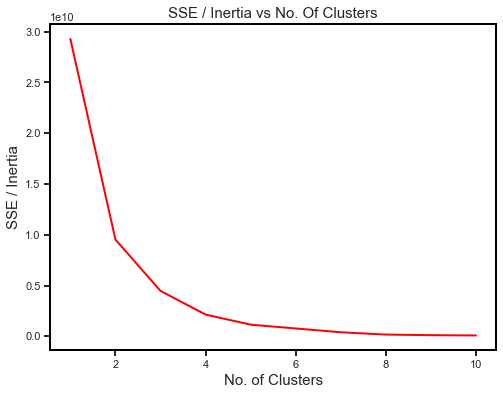

In [31]:
# Cluster Table of distributions
from sklearn.cluster import KMeans

def drawSSEPlot(df, column_indices, ret_clus=5, n_clusters=8, max_iter=300, tol=1e-04, init='k-means++', n_init=10, algorithm='auto'):
    inertia_values = []    
    for i in range(1, n_clusters+1):
        km = KMeans(n_clusters=i, max_iter=max_iter, tol=tol, init=init, n_init=n_init, random_state=42, algorithm=algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
        if i == ret_clus:
            ret = km
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(range(1, n_clusters+1), inertia_values, color='red')
    plt.xlabel('No. of Clusters', fontsize=15)
    plt.ylabel('SSE / Inertia', fontsize=15)
    plt.title('SSE / Inertia vs No. Of Clusters', fontsize=15)
    plt.grid()
    plt.show()
    return ret

# select final number of clusters based on SSE plot
n_clusters = 5
km = drawSSEPlot(ct, range(len(ct.columns)), n_clusters=10, ret_clus=n_clusters)

In [32]:
# assign cluster to STATE
ct['cluster'] = km.labels_
ct['tot'] = state_tot
ct.sort_values(by=['cluster'])
# instances by cluster
ct[['cluster','tot']].groupby(['cluster']).sum(['tot'])

RAC1P,tot
cluster,
0,297800
1,131142
2,142569
3,226212
4,317492


In [33]:
# add cluster to train and test instances
X_train_c = pd.merge(X_train, ct['cluster'], left_on='STATE', right_index=True)
X_test_c = pd.merge(X_test, ct['cluster'], left_on='STATE', right_index=True)
df_test_c = pd.merge(df_test, ct['cluster'], left_on='STATE', right_index=True)
df_test_c['pred_c'] = 1

In [34]:
# cluster specific ThresholdOptimizer post-processing
for i in range(n_clusters):
    sub = X_train_c['cluster']==i
    postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
    postprocess_est.fit(X_train.loc[sub, pred_atts], y_train[sub], sensitive_features=X_train.loc[sub, 'RAC1P'])
    sub = X_test_c['cluster']==i
    y_pred_s = postprocess_est.predict(X_test_c.loc[sub, pred_atts], sensitive_features=X_test_c.loc[sub, 'RAC1P'], random_state=42).astype(int)
    sub = df_test_c['cluster']==i
    df_test_c.loc[sub, 'pred_c'] = y_pred_s
# extend decode
decode['pred_c'] = decode['class']

In [35]:
df_test_c

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup,pred_b,pred_a,cluster,pred_c
517717,28,1,18,5,4700,37,50,2,1,12,0,0,16,0,4,1,1,0,1
507501,23,1,21,5,1430,36,40,1,1,12,1,0,4,0,3,0,0,0,0
537835,33,1,21,1,4710,17,50,2,1,12,1,1,16,0,4,1,1,0,1
539525,54,1,21,3,1021,13,40,1,1,12,1,3,3,0,3,0,0,0,0
554172,62,1,23,1,4760,138,44,1,1,12,0,4,16,1,4,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619013,25,1,16,5,4600,54,38,2,1,47,0,0,15,0,3,0,0,2,0
1615023,56,1,16,1,5120,54,40,2,1,47,0,3,17,0,3,0,0,2,0
1611996,66,1,16,1,6260,24,39,1,1,47,0,4,19,0,3,0,0,2,0
1612388,50,8,18,1,4500,54,30,2,1,47,0,2,15,0,2,0,0,2,0


In [36]:
# To compute P(pred.good|true.good) we need the dd.DD object
metric_c = lambda ctg: eop_mean(ctg, disc_c)

In [37]:
# discrimination in overall test set
# DD(filename or dataframe, unprotected item, negative decision, negative truth)
disc_c = dd.DD(df_test_c[disc_all+['pred_c']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_c=<=50K', trueBadItem='class=<=50K', valuedecode=decode,
               codes=disc_a.codes) # extends the coding of items as disc_a 
# all protected vs unprotected
ctg = disc_c.ctg_any()
disc_c.print(ctg)
print("Metric = {:f}".format(metric_c(ctg)))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White                                     RAC1P=White
           |pred_c=<=50K|pred_c=>50K|                      |pred_c=<=50K|pred_c=>50K|      
class=<=50K|       53968|      31481| 85449     class=<=50K|      214676|      46821|261497
class=>50K |       19240|      16196| 35436     class=>50K |       87922|      78981|166903
           |       73208|      47677|120885                |      302598|     125802|428400
Metric = 0.013335


In [50]:
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_c, metric_c, True)
print('mean before', np.mean([abs(x) for x in xs]), 'after', np.mean([abs(y) for y in ys]), 'len', len(xs))
xs, ys, descs, acs = data_plot(disc_b, metric_b, disc_c, metric_c)

mean before 0.2678636412886513 after 0.10492676405670442 len 262


C:\Users\ruggieri\AppData\Local\Temp\ipykernel_13372\2688792719.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


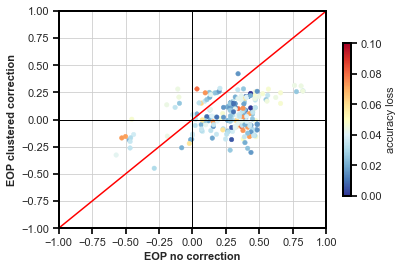

In [51]:
plt.scatter(xs, ys, c =acs, linewidths = .5, marker ="o", cmap="RdYlBu_r", s=20)
plt.xlabel("EOP no correction", fontweight="bold")
plt.ylabel("EOP clustered correction", fontweight="bold")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axline((0, 0), (1, 1), linewidth=1.5, color='r')
plt.axline((0, 0), (0, 1), linewidth=1, color='black')
plt.axline((0, 0), (1, 0), linewidth=1, color='black')
plt.colorbar(label="accuracy loss", orientation="vertical", shrink=.7)
plt.clim(0,.1)
#plt.savefig('fig2.pdf', bbox_inches='tight', dpi=400)
plt.show()

In [41]:
y_pred_c = df_test_c['pred_c']
summary_c = MetricFrame(metrics=true_positive_rate,
                          y_true=y_test,
                          y_pred=y_pred_c,
                          sensitive_features=X_test['RAC1P'])
summary_c.overall-summary_c.by_group

RAC1P
1   -0.000502
2    0.000049
3   -0.002338
4     0.06988
5    0.007986
6    0.001715
7   -0.011807
8      0.0091
9    0.005819
Name: true_positive_rate, dtype: object

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


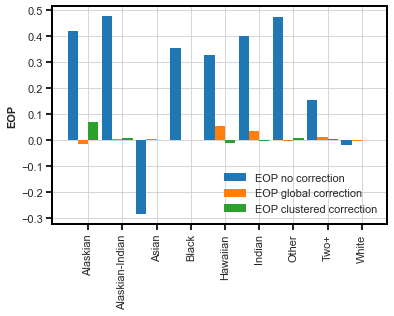

In [42]:
X_axis = np.arange(len(pretty_rac1p))
pos = np.argsort(pretty_rac1p)
plt.bar(X_axis - 0.45, np.array(summary_b.overall-summary_b.by_group)[pos], 0.3, label='EOP no correction')
plt.bar(X_axis - 0.15, np.array(summary_a.overall-summary_a.by_group)[pos], 0.3, label='EOP global correction')
plt.bar(X_axis + 0.15, np.array(summary_c.overall-summary_c.by_group)[pos], 0.3, label='EOP clustered correction')
plt.xticks(X_axis, sorted(pretty_rac1p))
plt.xticks(rotation=90)
plt.legend(loc=4)
plt.ylabel("EOP", fontweight="bold")
#plt.savefig('fig0.pdf', bbox_inches='tight', dpi=400)
plt.show()